In [1]:
## Feature Engineering Exploration here.

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score
## Logistic Regression for univaraite feature evaluation
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import math
warnings.filterwarnings("ignore")

In [3]:
## Final data frame produced by Kevin... God work.
df = pd.read_pickle('F:////League of legends Game Prediction//LoL-PlaybyPlay-Win-Prediction//data_merged//data_merged//df_final_merge.pkl')

In [4]:
## Cut data into early game stage
## Cut-off standard here: cut off at 20 min, or second dragon killed.
## we might only pick game where game length is > 30 min at least for training. Not implement for now.

df['dragon_kill'] = df['OBJECTIVE_AIR_DRAGON']+df['OBJECTIVE_CHEMTECH_DRAGON']+df['OBJECTIVE_EARTH_DRAGON']+df['OBJECTIVE_FIRE_DRAGON']+df['OBJECTIVE_HEXTECH_DRAGON']
Dragon_Kill = pd.DataFrame(df[['dragon_kill','matchId','sampleTimestamp','teamIdStr']].groupby(['matchId','sampleTimestamp'])['dragon_kill'].sum())
Dragon_Kill = Dragon_Kill.rename(columns={'dragon_kill':'Total_dragon_kill'})
df = df.merge(Dragon_Kill,on = (['matchId','sampleTimestamp']),how='left')

df['Total_dragon_kill'] = df['Total_dragon_kill']/5

time_cutoff = 60000*20
dragon_cutoff = 3
mask1 = df['sampleTimestamp'] < time_cutoff
mask2 = df['Total_dragon_kill']<dragon_cutoff

dfearly = df[(mask1)&(mask2)]

In [5]:
T1_dfearly = dfearly[dfearly['teamIdStr']=='TEAM1']
T2_dfearly = dfearly[dfearly['teamIdStr']=='TEAM2']

In [6]:
## Total gold should matter here. For each team, we should be able to panelly transform the dataframe to team, sampleTimestamp, and features.
## process totalGold into flat dataframe per game by sampleTimestamp, and add total gold differences between two team by timestamp.

def gold_handler(df):
    process_df = df[['matchId','sampleTimestamp','participantId','totalGold']]
    process_df = process_df.groupby(['matchId','sampleTimestamp','participantId']).first().unstack(level=2).reset_index()
    renamedict = {}
    renamedict[0] = 'matchId'
    renamedict[1] = 'sampleTimestamp'
    for i in range(2,7):
        renamedict[i] ='totalGold_p'+str(i-1)
    return pd.DataFrame(np.array(process_df)).rename(columns = renamedict).set_index(['matchId','sampleTimestamp'])
T1_gold = gold_handler(T1_dfearly)
T2_gold = gold_handler(T2_dfearly)
gold_diff = T1_gold - T2_gold

colrename = {}
for cn in gold_diff.columns:
    colrename[cn] = cn+'_diff'
gold_diff.rename(columns = colrename,inplace =True)
T1_gold = T1_gold.merge(gold_diff,on =['matchId','sampleTimestamp'],how='left')

In [79]:
## Basic data analyais ploting - bucket scatter
def bucket_scatter(df,X,Y,total_bins= 30):
    x = df[X]
    df1 = df[[X,Y]]
    if x.min() ==0:
        check = 1
    else: 
        check = x.min()
    bins = np.geomspace(check,x.max(), total_bins)
    data_cut = pd.cut(df1[X],bins)  
    return df1.groupby(by = data_cut).aggregate(np.mean).plot.scatter(x=X,y=Y,figsize = (10,7))       

In [21]:
charfeatures = ['xp','damageStats_totalDamageTaken','damageStats_totalDamageDoneToChampions','championStats_movementSpeed',
                'championStats_magicResist','championStats_magicPenPercent','championStats_healthMax','championStats_ccReduction',
                'championStats_attackSpeed','championStats_attackDamage','championStats_armor','championStats_abilityPower']


In [23]:
T1_dfearly

,matchId,participantId,sampleTimestamp,currentGold,goldPerSecond,jungleMinionsKilled,level,minionsKilled,timeEnemySpentControlled,totalGold,...,OBJECTIVE_HEXTECH_DRAGON,OBJECTIVE_RIFTHERALD,OBJECTIVE_WATER_DRAGON,ITEMS_PURCHASED,TURRET_PLATE_KILL_BOT_LANE,TURRET_PLATE_KILL_MID_LANE,TURRET_PLATE_KILL_TOP_LANE,WARDS_PLACED,dragon_kill,Total_dragon_kill
0,NA1_4572960672,1,0,500,0,0,1,0,0,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NA1_4572960672,2,0,500,0,0,1,0,0,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NA1_4572960672,3,0,500,0,0,1,0,0,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NA1_4572960672,4,0,500,0,0,1,0,0,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NA1_4572960672,5,0,500,0,0,1,0,0,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898230,NA1_4583937113,1,1140000,1066,0,15,11,112,73325,6051,...,0.0,0.0,0.0,8.0,1.0,2.0,3.0,0.0,1.0,2.0
2898231,NA1_4583937113,2,1140000,191,0,76,10,25,385327,7611,...,0.0,0.0,0.0,13.0,1.0,2.0,3.0,0.0,1.0,2.0
2898232,NA1_4583937113,3,1140000,58,0,8,12,127,64966,6863,...,0.0,0.0,0.0,17.0,1.0,2.0,3.0,0.0,1.0,2.0
2898233,NA1_4583937113,4,1140000,744,0,0,11,170,18603,7664,...,0.0,0.0,0.0,19.0,1.0,2.0,3.0,0.0,1.0,2.0


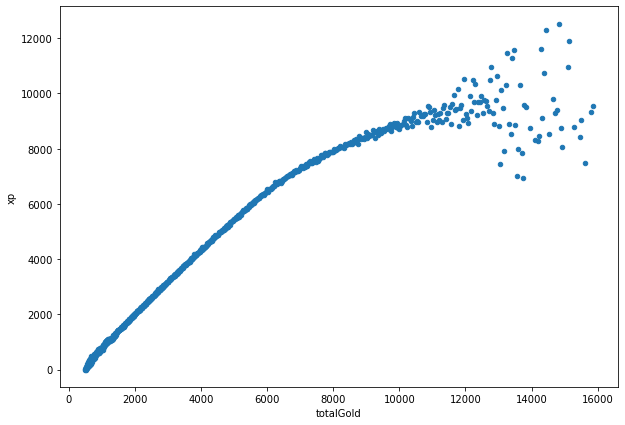

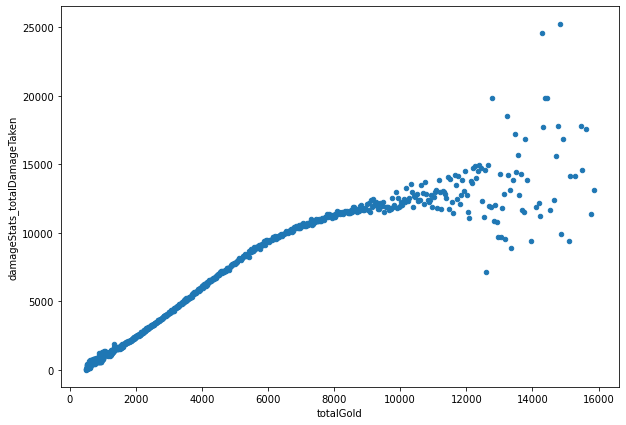

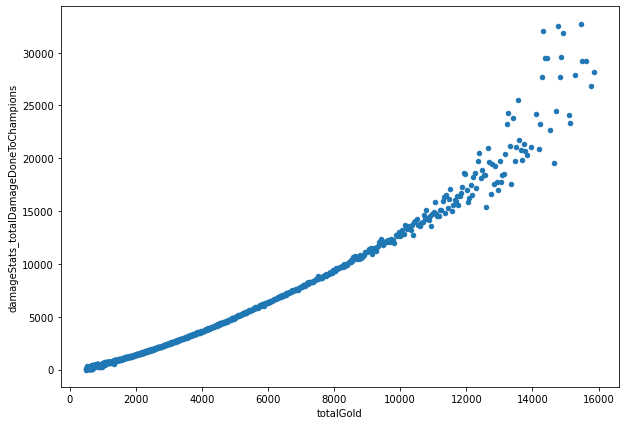

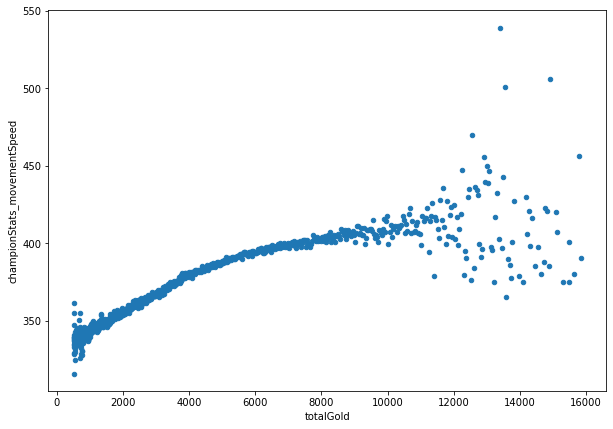

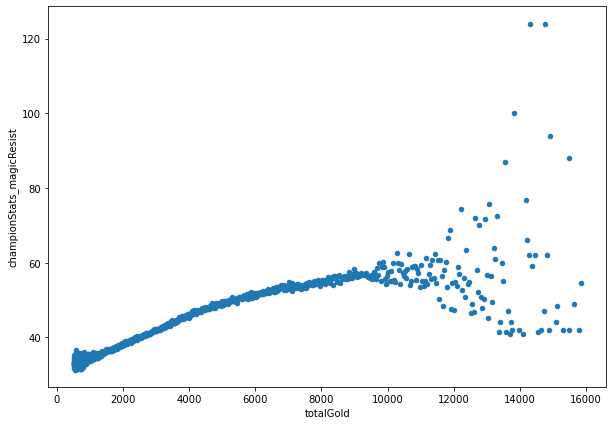

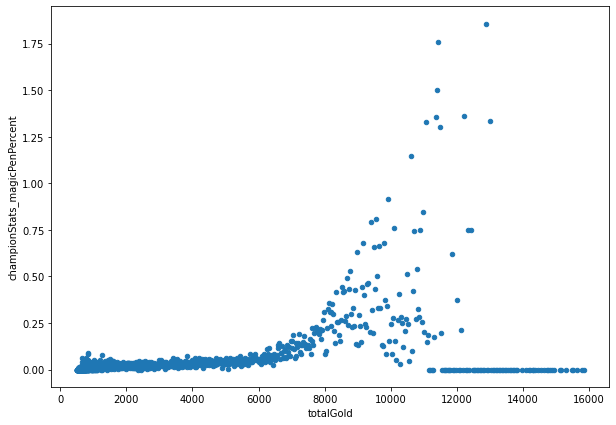

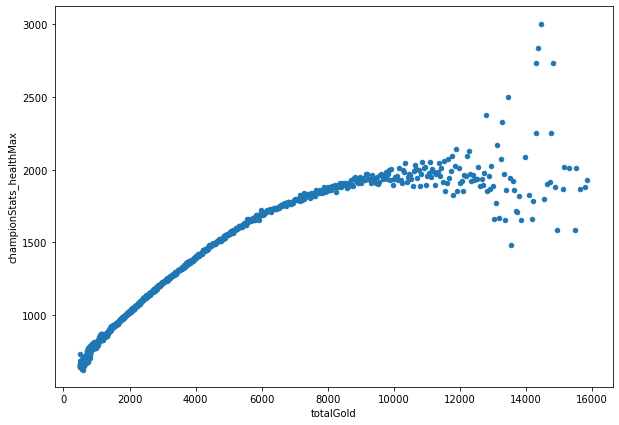

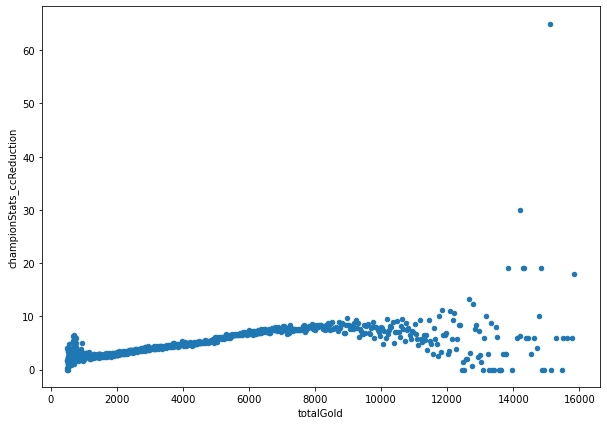

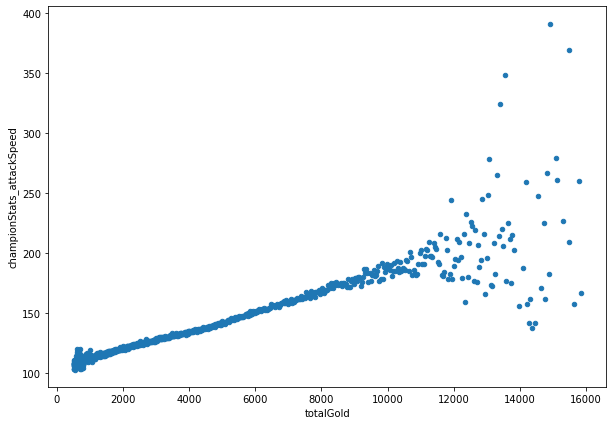

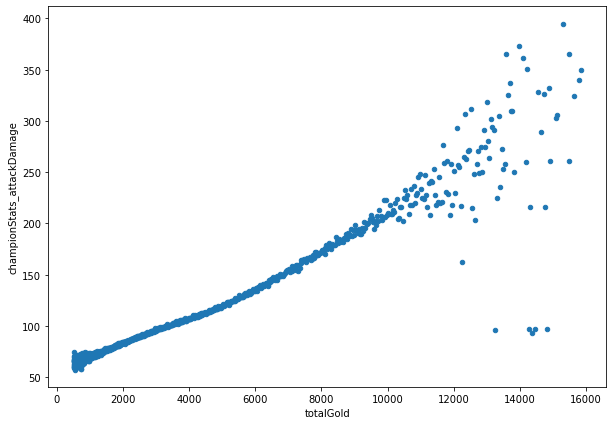

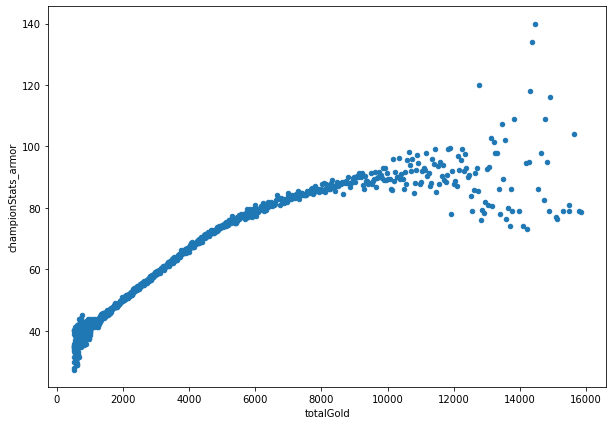

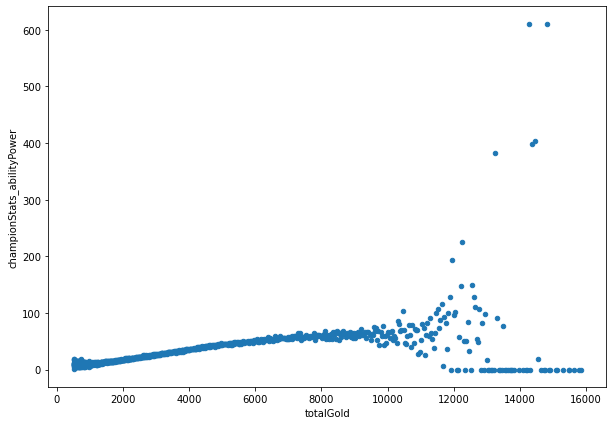

In [22]:
for char in charfeatures:
    bucket_scatter(T1_dfearly,'totalGold',char,total_bins =1000)

xp: might include in the prediction.

ability power: Bad feature. Looks very suspecious..

armor: Looks ok. I'm not too sure if this has taht much prediciton power though.

Attack damage: might be useful feature. not linear relationship with gold.

Attack speed: drop out.

cc Reduction: Not really correlated to gold. In order to utilize this feature, we might need to cateogrize champ.

magical penetration: bad data.

Total Damage done to champs: good information, aside from gold.


In [135]:
def univariate_feature_evaluation(df,featurelist):
    X = df[featurelist]
    Y = df[['win']].astype('int')
    simple_model = LogisticRegression()
    simple_model.fit(X,Y)    
    probs = simple_model.predict_proba(X)
    print(featurelist[0]+':'+str(accuracy_score(simple_model.predict(X),Y))+ '|    entropy'+str(metrics.log_loss(Y, probs)))
    
    feature_importance = pd.DataFrame(featurelist, columns = ["feature"])
    feature_importance["importance"] = pow(math.e, simple_model.coef_[0]*100)
    feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
    
    ax = feature_importance.plot.barh(x='feature', y='importance')
    plt.show()
    return simple_model.coef_[0]

In [71]:
univariate_feature_evaluation(T1_dfearly,['totalGold'])
print('')
for feature in charfeatures:
    univariate_feature_evaluation(T1_dfearly,[feature])
    print('')

totalGold:0.48896432096180875|    entropy0.6929628950497468

xp:0.5194933756018781|    entropy0.6922745331089302

damageStats_totalDamageTaken:0.5110356790381912|    entropy0.6926962657284741

damageStats_totalDamageDoneToChampions:0.52444796682318|    entropy0.6911813080709215

championStats_movementSpeed:0.5105432106149874|    entropy0.6927849101618558

championStats_magicResist:0.519571133773963|    entropy0.6923439853624892

championStats_magicPenPercent:0.5110197286439174|    entropy0.692901342079584

championStats_healthMax:0.522878846786494|    entropy0.6922166964679684

championStats_ccReduction:0.5143972246313964|    entropy0.6925216453616171

championStats_attackSpeed:0.5164538285930755|    entropy0.6923650818103577

championStats_attackDamage:0.5140084337709723|    entropy0.6923775261488124

championStats_armor:0.5215848710510312|    entropy0.6922992208777841

championStats_abilityPower:0.512311710580096|    entropy0.6925042004604604



### use totalGold as a benchmark here
### Valuable feature are:
### xp.
### damageStats_totalDamageDoneToChampions
### championStats_magicResist
### championStats_healthMax
### championStats_armor

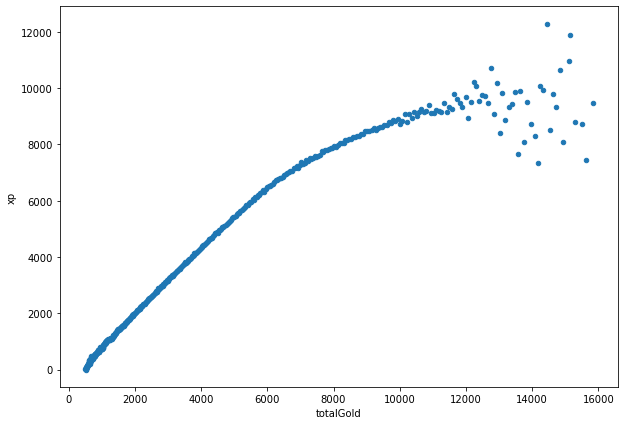

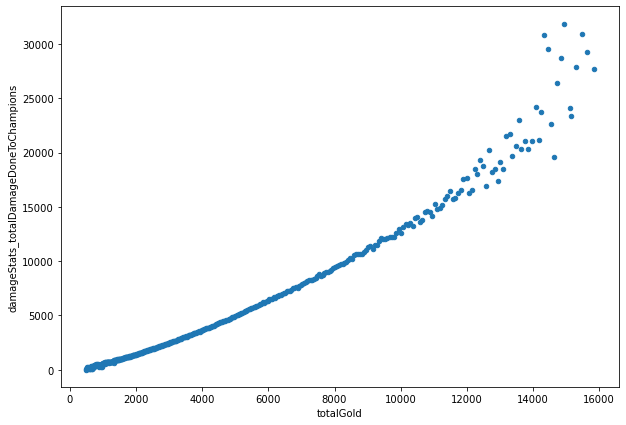

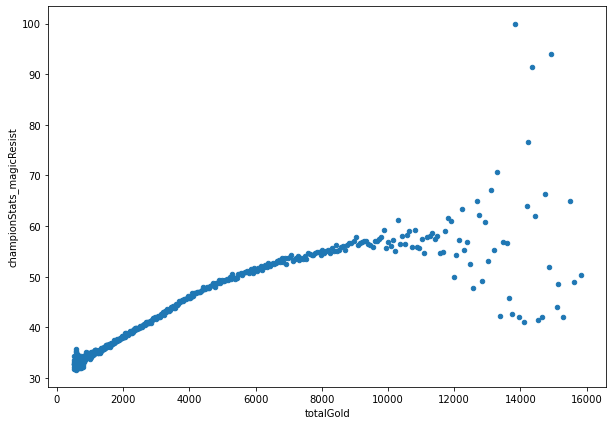

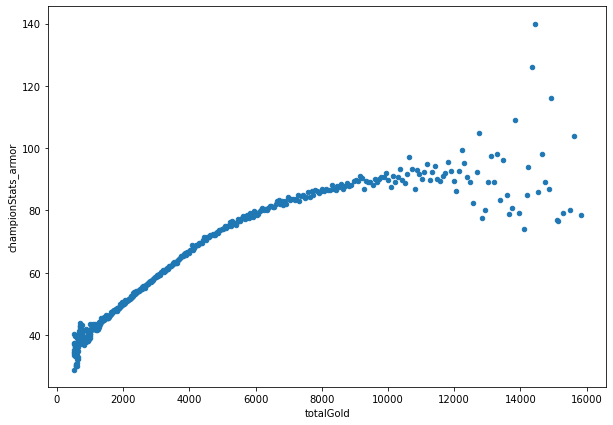

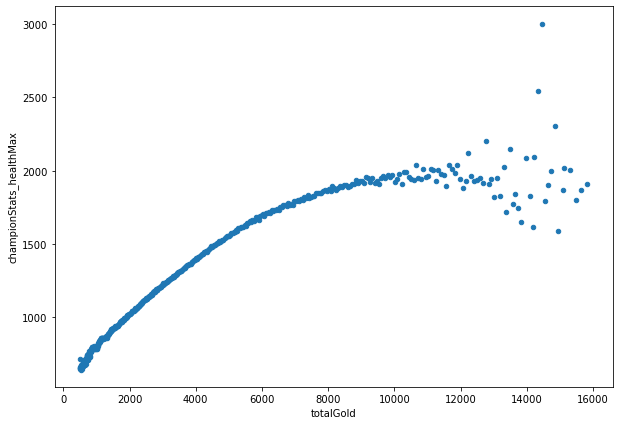

In [74]:
## New iterations
newiter = ['xp','damageStats_totalDamageDoneToChampions','championStats_magicResist','championStats_armor','championStats_healthMax']
for char in newiter:
    bucket_scatter(T1_dfearly,'totalGold',char,total_bins =500)

<AxesSubplot:xlabel='championStats_healthMax', ylabel='championStats_armor'>

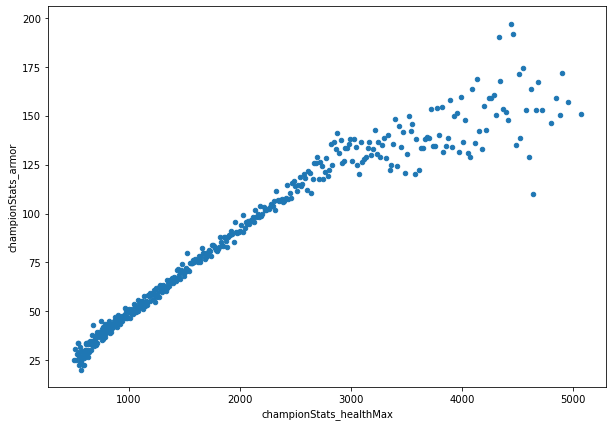

In [77]:
## armor and max health seems to be highly correlated. Unless health > 3000 [Tank champs most often]
## this suggests that for this feature, we should only keep: top, jungle, and support in most case.
bucket_scatter(T1_dfearly,'championStats_healthMax','championStats_armor',total_bins =500)

<AxesSubplot:xlabel='xp', ylabel='damageStats_totalDamageDoneToChampions'>

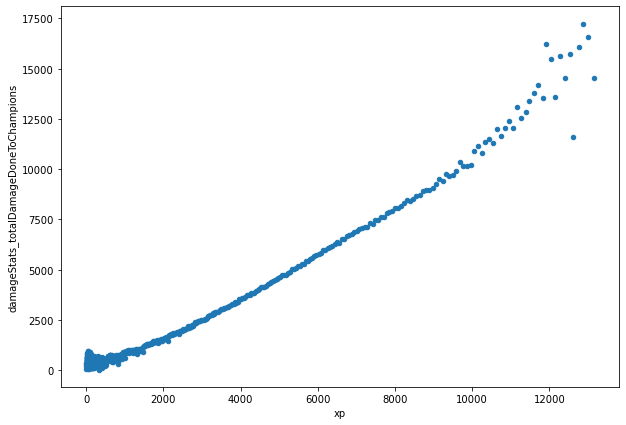

In [82]:
## XP and total damage done seems to be correlated as well,unelss xp > 9000. [ Non linear pattern here.]
## Probaly still better keep both data column. 
## Thoughts: can we create a weighted average version of XP? 
## for XP differences, a better representation might be: average XP differences by team
## Max XP - average(XP) in other team [exclude support]. Any late game carrier here?
## adc XP - mid XP in enemy team.
## adc XP - top XP in enemy team.
bucket_scatter(T1_dfearly,'xp','damageStats_totalDamageDoneToChampions',total_bins =1000)

In [86]:
## validate the prior
def champ_char_handler(df,char):
    process_df = df[['matchId','sampleTimestamp','participantId',char]]
    process_df = process_df.groupby(['matchId','sampleTimestamp','participantId']).first().unstack(level=2).reset_index()
    renamedict = {}
    renamedict[0] = 'matchId'
    renamedict[1] = 'sampleTimestamp'
    for i in range(2,7):
        renamedict[i] =str(char)+'_p'+str(i-1)
    return pd.DataFrame(np.array(process_df)).rename(columns = renamedict).set_index(['matchId','sampleTimestamp'])

In [406]:
## XP and total damage done seems to be correlated as well,unelss xp > 9000. [ Non linear pattern here.]
## Probaly still better keep both data column. 
## Thoughts: can we create a weighted average version of XP? 
## for XP differences, a better representation might be: average XP differences by team [ Exclude support]
## Max XP - average(XP) in other team [exclude support]. Any late game carrier here?
## adc XP - mid XP in enemy team. [if mid is 2 level up than ad. this is very bad]

test = champ_char_handler(T1_dfearly,'xp').merge(champ_char_handler(T2_dfearly,'xp').reset_index(),on =['matchId','sampleTimestamp'],how='left')

test['T1maxxp'] = test[['xp_p1_x','xp_p2_x','xp_p3_x','xp_p4_x','xp_p5_x']].max(axis=1)
test['T1avg'] = test[['xp_p1_x','xp_p2_x','xp_p3_x','xp_p4_x']].mean(axis=1)
test['T2avg'] = test[['xp_p1_y','xp_p2_y','xp_p3_y','xp_p4_y']].mean(axis=1)
test['xplead'] = test['T1maxxp']-test['T2avg']
test['adc_xpgap_mid'] = test['xp_p4_x'] - test['xp_p3_y']
test['xp_avggap'] = test['T1avg']-test['T2avg']
test = test[['matchId','sampleTimestamp','T1avg','xp_avggap','adc_xpgap_mid','xplead']]

xp_avggap:0.6496876573553826|    entropy0.6016280067666091


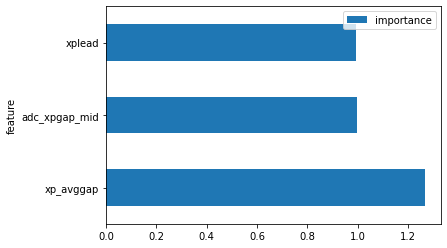

xp_avggap:0.6494284104675917|    entropy0.6016908173912572


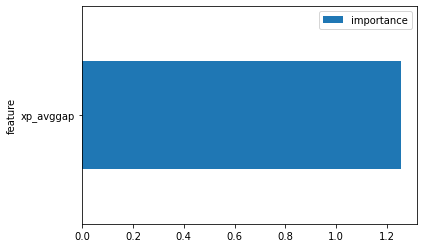

xplead:0.5976588011825646|    entropy0.6597767053163024


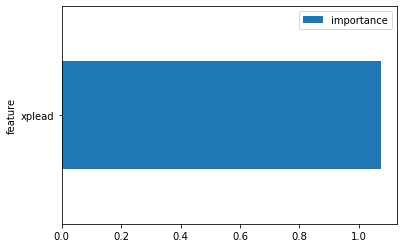

T1avg:0.5187679790209442|    entropy0.6921491442507827


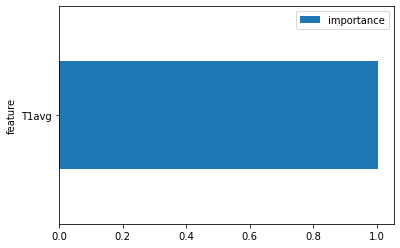

adc_xpgap_mid:0.5558402839750525|    entropy0.6784888047914526


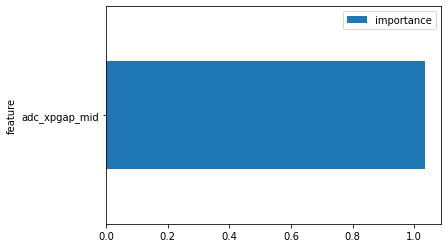

array([0.00033503])

In [257]:
## good stuff - Great Feature here! This is clearly way better than xp itself
## let's use xp_avggap, xplead, adc_xpgap_mid for now.
newtest = test.merge(T1_dfearly[['matchId','sampleTimestamp','win']].drop_duplicates(),on =['matchId','sampleTimestamp'],how='left')
## feature importance evaluation [ after * 100 scaling].
univariate_feature_evaluation(newtest,['xp_avggap','xplead','adc_xpgap_mid'])
univariate_feature_evaluation(newtest,['xp_avggap'])
univariate_feature_evaluation(newtest,['xplead'])
univariate_feature_evaluation(newtest,['T1avg'])
univariate_feature_evaluation(newtest,['adc_xpgap_mid'])

xp_avggap:0.6496876573553826|    entropy0.6016280067666091


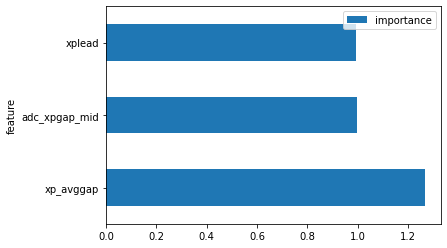

array([ 2.36331105e-03, -5.54762437e-05, -1.53223097e-05])

In [259]:
## OK - let's apply xp_avggap','xplead','adc_xpgap_mid, but with standardization.
univariate_feature_evaluation(newtest,['xp_avggap','xplead','adc_xpgap_mid'])

In [308]:
## cross timestamps standardization [ For later use case]
demean = lambda df: df - df.mean()
standardize = lambda df: df/df.var() if df.var()!=0 else df/1

test = pd.concat([test[['matchId','sampleTimestamp']],\
           test.groupby(['matchId']).transform(demean)[['xp_avggap','adc_xpgap_mid','xplead']]],axis=1)

test = pd.concat([test[['matchId','sampleTimestamp']],\
           test.groupby(['matchId']).transform(standardize)[['xp_avggap','adc_xpgap_mid','xplead']]],axis=1)

test = test.merge(T1_dfearly[['matchId','sampleTimestamp','win']].drop_duplicates(),on =['matchId','sampleTimestamp'],how='left')
## need to fill na. forward fill here
test = test.groupby(['matchId'])[list(test.columns)].ffill()

xp_avggap:0.6363912833219497|    entropy0.6675365173295309


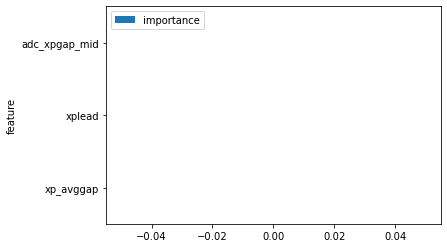

array([61.17791022, 25.20435232, 13.27120851])

In [407]:
## standardization didn't loss that much power
test = test.set_index(['matchId','sampleTimestamp'])
test = test-test.mean()
test = test/test.var()
test = test.groupby(['matchId'])[list(test.columns)].ffill()
newtest = test.merge(T1_dfearly[['matchId','sampleTimestamp','win']].drop_duplicates(),on =['matchId','sampleTimestamp'],how='left')
univariate_feature_evaluation(newtest,['xp_avggap','xplead','adc_xpgap_mid'])

In [374]:
## let's check total damage done as well.
test = champ_char_handler(T1_dfearly,'damageStats_totalDamageDoneToChampions').merge(champ_char_handler(T2_dfearly,'damageStats_totalDamageDoneToChampions').reset_index(),on =['matchId','sampleTimestamp'],how='left')
test.loc[:,(test.columns!='damageStats_totalDamageDoneToChampions_p5_x')\
         &(test.columns!='damageStats_totalDamageDoneToChampions_p5_y')]

,matchId,sampleTimestamp,damageStats_totalDamageDoneToChampions_p1_x,damageStats_totalDamageDoneToChampions_p2_x,damageStats_totalDamageDoneToChampions_p3_x,damageStats_totalDamageDoneToChampions_p4_x,damageStats_totalDamageDoneToChampions_p1_y,damageStats_totalDamageDoneToChampions_p2_y,damageStats_totalDamageDoneToChampions_p3_y,damageStats_totalDamageDoneToChampions_p4_y
0,NA1_4459931201,0,0,0,0,0,0,0,0,0
1,NA1_4459931201,60000,0,0,68,0,0,0,0,185
2,NA1_4459931201,120000,387,0,133,0,156,0,0,185
3,NA1_4459931201,180000,824,539,374,328,565,0,303,821
4,NA1_4459931201,240000,898,539,596,328,640,322,736,821
...,...,...,...,...,...,...,...,...,...,...
200576,NA1_4592506957,720000,4264,2828,4319,6070,5336,4298,6775,5361
200577,NA1_4592506957,780000,4788,3273,4319,6070,5336,4643,6775,7422
200578,NA1_4592506957,840000,4788,3372,4485,6115,5336,4643,6775,10453
200579,NA1_4592506957,900000,4788,3372,5593,6831,7501,4643,6775,10453


damageStats_totalDamageDoneToChampions_p2_x:0.6415612645265504|    entropy0.622668728070449


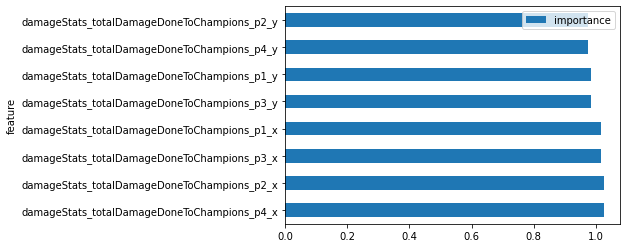

array([ 0.00024686, -0.00026517,  0.00017282, -0.00015837,  0.00025008,
       -0.00025739,  0.00016856, -0.00016668])

In [362]:
## My sense is that total damage might only matter for 2 position for early game: jungle. [More fight, more ganks, more damage]
## Total damage, and Total damage differences. 
## Other information can be reflected from position information later.

newtest = test.merge(T1_dfearly[['matchId','sampleTimestamp','win']].drop_duplicates(),on =['matchId','sampleTimestamp'],how='left')
univariate_feature_evaluation(newtest,['damageStats_totalDamageDoneToChampions_p2_x','damageStats_totalDamageDoneToChampions_p2_y',
                                      'damageStats_totalDamageDoneToChampions_p3_x','damageStats_totalDamageDoneToChampions_p3_y',
                                      'damageStats_totalDamageDoneToChampions_p4_x','damageStats_totalDamageDoneToChampions_p4_y',
                                      'damageStats_totalDamageDoneToChampions_p1_x','damageStats_totalDamageDoneToChampions_p1_y',])
## 57% prediction power here. Not bad - look at parameter here. It does say that jungle gank rate has different weights (reflect some 
## ganking sucess rate, than purely identical differences)

In [ ]:
## let's try these features for now - for our new LSTM model, before we go into more exotic features.


In [410]:
## check categorical features
categorical_features =['matchId','sampleTimestamp','TURRET_PLATE_KILL_BOT_LANE','TURRET_PLATE_KILL_MID_LANE','TURRET_PLATE_KILL_TOP_LANE','dragon_kill']
categorical_feature_T1 = T1_dfearly[categorical_features]
categorical_feature_T1 = categorical_feature_T1.groupby(['matchId','sampleTimestamp']).first()
## These categorical features might only matter by differences from my perpsective
categorical_feature_T2 = T2_dfearly[categorical_features]
categorical_feature_T2 = categorical_feature_T2.groupby(['matchId','sampleTimestamp']).first()

In [ ]:
## Turrent plate kill won't really matter that much if we incorporate gold information into account.
## that being said, include these indicator variable might tell us first turrent informatino, and timeline of these
## first turrent.
## and same story as dragon_kill..
## same story here. both differences and level should matter here.

In [420]:
categorical_feature_T1.merge(categorical_feature_T2,on =['matchId','sampleTimestamp'],how='left')

TURRET_PLATE_KILL_BOT_LANE_x  \
matchId        sampleTimestamp                                 
NA1_4459931201 0                                         0.0   
               60000                                     0.0   
               120000                                    0.0   
               180000                                    0.0   
               240000                                    0.0   
...                                                      ...   
NA1_4592506957 720000                                    1.0   
               780000                                    1.0   
               840000                                    1.0   
               900000                                    1.0   
               920000                                    1.0   

                                TURRET_PLATE_KILL_MID_LANE_x  \
matchId        sampleTimestamp                                 
NA1_4459931201 0                                         0.0   
               60000                                     0.0   
               120000                                    0.0   
               180000                                    0.0   
               240000                                    0.0   
...                                                      ...   
NA1_4592506957 720000                                    0.0   
               780000                                    0.0   
               840000                                    0.0   
               900000                                    0.0   
               920000                                    0.0   

                                TURRET_PLATE_KILL_TOP_LANE_x  dragon_kill_x  \
matchId        sampleTimestamp                                                
NA1_4459931201 0                                         0.0            0.0   
               60000                                     0.0            0.0   
               120000                                    0.0            0.0   
               180000                                    0.0            0.0   
               240000                                    0.0            0.0   
...                                                      ...            ...   
NA1_4592506957 720000                                    0.0            0.0   
               780000                                    0.0            0.0   
               840000                                    0.0            0.0   
               900000                                    0.0            0.0   
               920000                                    0.0            0.0   

                                TURRET_PLATE_KILL_BOT_LANE_y  \
matchId        sampleTimestamp                                 
NA1_4459931201 0                                         0.0   
               60000                                     0.0   
               120000                                    0.0   
               180000                                    0.0   
               240000                                    0.0   
...                                                      ...   
NA1_4592506957 720000                                    1.0   
               780000                                    1.0   
               840000                                    1.0   
               900000                                    1.0   
               920000                                    1.0   

                                TURRET_PLATE_KILL_MID_LANE_y  \
matchId        sampleTimestamp                                 
NA1_4459931201 0                                         0.0   
               60000                                     0.0   
               120000                                    0.0   
               180000                                    0.0   
               240000                                    0.0   
...                                                      